In [1]:
## ---- Partition Cell Set Network Module Analysis ---- 0675.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Load 20K Data Sets Created in 0670.00.00.Carotid.SC.NotebookPartition.Network.Modules.01
## Perform Module DE Analysis on Selected Clusters
## Create Module and Gene Tabulated Files, Also For IPA
## Find Network Stats for earch Partition (FDR Thresholds)

In [1]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [2]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [3]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)

## Get the igraph utilities
source('/gpfs/home/devans/code/Utilities/fromSara/setup_igraph.r')
source('/gpfs/home/devans/code/Utilities/fromSara/recursive_louvain.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_score.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_overlap.r')
source('/gpfs/home/devans/code/Utilities/fromSara/plot_by_cluster.r')

## Alternate to stat_parm utility in igraph utilities (does not assume log10 data)
stat_parm2 <- function(gf, expdata){
    
    ## Remove expression values not in the network, get antilog
    # expdata_filt <- 10 ^ log10expdata[,V(gf)$name]
    expdata_filt <- expdata[,V(gf)$name]
    
    ## Compute the node expression stats, including coeff of variation, add to network
    V(gf)$mean <- apply(expdata_filt, 2, mean)
    V(gf)$sd <- apply(expdata_filt, 2, sd)
    V(gf)$cv <- V(gf)$sd/V(gf)$mean
    V(gf)$med <- apply(expdata_filt, 2, median)

    ## Compute the strength
    V(gf)$strength <- strength(gf, weights = abs(E(gf)$pcor))
    return(gf)
    }
## Alternate to plot function in utility

plot_parm2 <- function (gf) {

    V(gf)$color <- 'red'
    
    E(gf)$color[E(gf)$pcor > 0] <- 'green'
    E(gf)$color[E(gf)$pcor < 0] <- 'orange'
    fedthick <- 100 * abs(E(gf)$pcor)
    V(gf)$label.cex = .1
    E(gf)$label.cex = .1
    V(gf)$label <- paste(substr(V(gf)$v27,1,10),
                                   round(V(gf)$strength,3), sep = '\n')
    E(gf)$width <- fedthick
    E(gf)$label <- round(E(gf)$pcor, 4)
    V(gf)$size <- 1

    return(gf)
    }

In [6]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [10]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [11]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]


doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

In [12]:
## Loop through the partitions and perform analysis, making networks
## Determine the number of partitions
np <- length(celltypes6)
diff_exp_qval_cut <- 0.05

for (p in 1:6) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    
    ## Read partition cell data set, expression data, and diff expression data
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    partn_exp <- t(exprs(partn_cds))
    if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
        de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)    
        }
    
    ## Save everything before plotting    
    net2 <- readRDS('Network.20k.rds')
    net2_clust <- readRDS('Louvain.Clust.20k.rds')
    clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')
    
    ## Get the significant differential expressed terms
    qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
        dplyr::select(gene_short_name, normalized_effect, q_value)
    
    ## Scale the expression data for computing Eigengenes (first extract only relavent genes)
    scalen_exp <- partn_exp[, V(net2)$name]
    scalen_exp <- scale(scalen_exp)
    
    
    ## Populate the partition nodes (genes) with their Diff Exp Status
    ## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
    rownames(qsig) <- short2geneid[qsig[,1]]
    V(net2)$diffexp <- 0
    genes <- V(net2)$name
    for (gene in 1:length(genes)) {
        de <- qsig[genes[gene],]
    if (!is.na(de[1])) {
        V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
        }
    }


    ## Get the module sizes
    mod_mems <- membership(net2_clust)
    mod_ids <- table(mod_mems)
    no_mods <- length(mod_ids)
    de_genes <- V(net2)$diffexp
    total_degenes <- sum(V(net2)$diffexp != 0)

    ## Create Eigengenes for each module
    Eigen_genes <- matrix(0, nrow = dim(partn_exp)[1], ncol = no_mods)
    mod_stats <- matrix(as.numeric(0), nrow = no_mods, ncol = 11)
    colnames(mod_stats) <- c('module_id', 'no_genes', 'eigen_pct_expl', 'cond_cor',
                             'cond_cor_pval', 'de_overlap_est', 'de_overlap_pval',
                             'cont_mat_11', 'cont_mat_12',
                            'cont_mat_21', 'cont_mat_22')
    i <- 1
    for (mod in names(mod_ids)) {
        mod_exp <- scalen_exp[, mod == mod_mems]

        ## Compute Eigengene and Associated Statistics
        prc_mod <- princomp(mod_exp)
        mod_stats[i, 1] <- mod
        mod_stats[i, 2] <- sum(mod == mod_mems)
        mod_stats[i, 3] <- 100 * round(prc_mod$sdev[1]^2 / sum(prc_mod$sdev^2), 4)
        Eigen_genes[, i] <- prc_mod$scores[, 1]

        ## Compute Eigengene to Cell Condition Correlation and and p-value
        mod_stats[i, 4] <- round(cor(Eigen_genes[, i], 1 * (colData(partn_cds)$condition == "healthy")), 4)
        if ((mod_stats[i, 4]) > 0) {
            mod_stats[i, 5] <- signif(cor.test(Eigen_genes[, i],
                                               1 * (colData(partn_cds)$condition == "healthy"),
                                 alternative = c("two.sided", "less", "greater")[3])$p.value, 2)
        } else {
            mod_stats[i, 5] <- signif(cor.test(Eigen_genes[, i],
                                               1 * (colData(partn_cds)$condition == "healthy"),
                                 alternative = c("two.sided", "less", "greater")[2])$p.value, 2)
        }

        ## Compute Fisher Exact Statistics and p-value for DE Genes 
        diffgenes <- sum(abs(V(net2)[V(net2)[mod == mod_mems]$name]$diffexp))
        pdg <- total_degenes
        mdg <- diffgenes
        pg <- dim(scalen_exp)[2]
        mg <- dim(mod_exp)[2]

        ## Generate the Contingency Matrix
        r22 <- mdg
        r21 <- pdg - r22 
        r12 <- mg - r22
        r11 <- pg - r22 - r21 - r12
        xmat <- rbind(c(r11, r12), c(r21, r22))

        ## Compute the Fisher Exact Test And Save
        fex_x <- fisher.test(xmat, alternative = 'greater')
        mod_stats[i, 6] <- round(fex_x$estimate, 4)
        mod_stats[i, 7] <- signif(fex_x$p.value, 4)

        ## Save the Contingency Matrix
        mod_stats[i, 8] <- r11
        mod_stats[i, 9] <- r12
        mod_stats[i, 10] <- r21
        mod_stats[i, 11] <- r22
        i <- i + 1
    }

    ## Get the Module Gene Tabulated Data
    nmarkers <- length(V(net2))
    part_mod_stats <- matrix('', nrow = nmarkers, ncol = 10)
    colnames(part_mod_stats) <- c('gene_short_name', 'gene_cards', 'module_id', 'gene_description',
            'biotype', 'de_norm_eff', 'de_pval', 'de_qval', 'coeff_var', 'strength')
    part_mod_stats <- as.data.frame(part_mod_stats, stringsAsFactors = FALSE)


    part_mod_stats[,1] <- V(net2)$v27
    # part_mod_stats[,2] <- V(net2)$v27
    part_mod_stats[,3] <- membership(net2_clust)
    part_mod_stats[,4] <- V(net2)$sdesc
    part_mod_stats[,5] <- V(net2)$v27type
    part_mod_stats[,6] <- NA
    part_mod_stats[,7] <- NA
    part_mod_stats[,8] <- NA
    for (i in 1:dim(part_mod_stats)[1]) {
        whichde <- which(part_mod_stats[i,1] == de_tab[,1])[1]
        if (!is.na(whichde)) {
            part_mod_stats[i,6] <- signif(de_tab$normalized_effect[whichde], 4)
            part_mod_stats[i,7] <- signif(de_tab$p_value[whichde], 4)
            part_mod_stats[i,8] <- signif(de_tab$q_value[whichde], 4)
            }
        }
    part_mod_stats[,9] <- signif(V(net2)$cv, 4)
    part_mod_stats[,10] <- signif(V(net2)$strength, 4)

    gc_hyper1 <- '=HYPERLINK(CONCAT("https://www.genecards.org/Search/Keyword?queryString=", '
    gc_hyper1 <- paste(gc_hyper1, 'A', 2:(nmarkers + 1), '), A', 2:(nmarkers + 1), ')', sep ='')
    part_mod_stats[,2] <- gc_hyper1

    ## Write the Tabulated Files
    mod_de_file <- 'Dense.20k.Network.Module.DE.Analysis.Rev1.txt'
    write.table(mod_stats, file = mod_de_file,
                row.names = FALSE, col.names = TRUE,
                sep = '\t', quote = FALSE)

    mod_genes_file <- 'Dense.20k.Network.Module.Genes.Rev1.txt'
    write.table(part_mod_stats, file = mod_genes_file,
                row.names = FALSE, col.names = TRUE,
                sep = '\t', quote = FALSE)
    
    ## Create an genes module for IPA analysis
    part_mod_stats_ipa <- as.data.frame(part_mod_stats, stringAsFactors = FALSE)
    part_mod_stats_ipa <- cbind(part_mod_stats_ipa, short2geneid[part_mod_stats_ipa[,1]],
                            '','', stringsAsFactors = FALSE)
    part_mod_stats_ipa[,12] <- 100 - as.numeric(part_mod_stats_ipa[,3])
    part_mod_stats_ipa[,13] <- as.numeric(part_mod_stats_ipa[,3])
    colnames(part_mod_stats_ipa) <- c(colnames(part_mod_stats), 'embl', 'm1', 'm2')
    mod_genes_file_ipa <- 'Dense.20k.Network.Module.Genes.IPA.Rev1.txt'
    write.table(part_mod_stats_ipa, file = mod_genes_file_ipa,
                row.names = FALSE, col.names = TRUE,
                sep = '\t', quote = FALSE)    
}

In [17]:
## Loop through the partition networks and get the stats
np <- length(celltypes6)

for (p in 1:6) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    

    ## Save everything before plotting    
    net2 <- readRDS('Network.20k.rds')
#     net2_clust <- readRDS('Louvain.Clust.20k.rds')
#     clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')
#     net2_reclust <- readRDS('Recuvsive.Louvain.Clust.20k.rds')
#     reclust_sc <- readRDS('Recursive.Louvain.Clust.Score.20k.rds') 
    
    pv <- round(max(E(net2)$pval), 5)
    qv <- round(max(E(net2)$qval), 5)
    lv <- round(max(E(net2)$lfdr), 5)
    
    cat(paste(celltypes6[p], ' Max p-value = ', pv, ', Max q-value = ', qv, '\n', sep = ''))
    
    }

1-Macrophages Max p-value = 7e-05, Max q-value = 0.1066
2-Endothelial Cells Max p-value = 2e-04, Max q-value = 0.30627
3-VSMCs Max p-value = 0.00013, Max q-value = 0.21578
4-Natural Killer Cells Max p-value = 0.00014, Max q-value = 0.08085
5-Cytotoxic T Lymphocytes Max p-value = 0.00101, Max q-value = 0.616
6-B Lymphocytes Max p-value = 0.00027, Max q-value = 0.15002


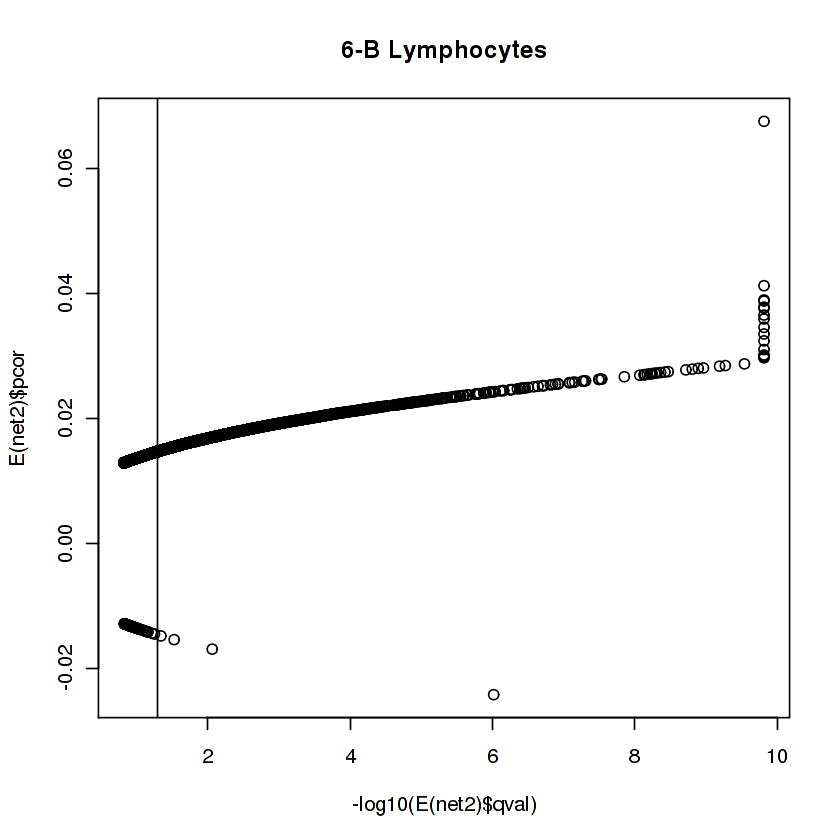

In [14]:
## Plot the last partition stats from prior cell
plot(-log10(E(net2)$qval), E(net2)$pcor, main = celltypes6[p])
abline(v = -log10(.05))